In [1]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from pprint import pprint
from scipy.cluster.hierarchy import dendrogram
import pandas as pd
import pickle

In [2]:
from matplotlib import font_manager, rc
font_name = font_manager.FontProperties(fname="/home/consulting/Jupyter/smnoh/font/NanumGothic.ttf").get_name()
rc('font', family=font_name)

### Node Pair Sampling 함수
https://arxiv.org/pdf/1806.01664.pdf

In [5]:
def HC(G):
    n = G.number_of_nodes()
    g = G.copy()

    # 노드를 정수로 변환
    if set(g.nodes()) != set(range(n)):
        g = nx.convert_node_labels_to_integers(g, label_attribute='noun')
        f = g.copy()  # old label을 꺼내기 위해 저장
    
    # 노드의 weight 초기화 및 계산
    # 노드별 degree 할당 -> 노드 i의 degree = w[i], wtot=총연결수*2 ([u,v]/[(v,u)] 두 번씩 더해서)
    w = {u: 0 for u in range(n)}
    wtot = 0
    for (u,v) in g.edges():
        if 'weight' not in g[u][v]:
            g[u][v]['weight'] = 1
        weight = g[u][v]['weight']
        w[u] += weight
        w[v] += weight
        wtot += weight
        if u != v:
            wtot += weight

    # cluster 리스트 초기화
    s = {u: 1 for u in range(n)}
    
    cc = [] # connected components
    D = []  # dendrogram 리스트
    #print(g.nodes())

    # cluster 계산
    u = n
    while n > 0:
        # nearest-neighbor chain
        chain = [list(g.nodes())[0]]
        while chain != []:
            a = chain.pop()
            dmin = np.inf
            b = -1
            # nearest-neighbor를 찾는 부분
            for v in g.neighbors(a): 
                if v != a:
                    #논문에서의 distance (d(i,j))
                    d = w[v] * w[a] / float(g[a][v]['weight']) / float(wtot)
                    
                    if d < dmin:
                        b = v
                        dmin = d
                    elif d == dmin:
                        b = min(b,v) # a와 가장 가까운 b 탐색 
            d = dmin
            if chain != []:
                c = chain.pop()
                if b == c:
                    # dendrogram 리스트에 값 대임
                    D.append([a,b,d,s[a] + s[b]])
                    # 변경된 cluster 기준으로 네트워크 업데이트
                    g.add_node(u)
                    neighbors_a = list(g.neighbors(a))
                    neighbors_b = list(g.neighbors(b))
                    for v in neighbors_a:
                        g.add_edge(u,v,weight = g[a][v]['weight'])
                    for v in neighbors_b:
                        if g.has_edge(u,v):
                            g[u][v]['weight'] += g[b][v]['weight']
                        else:
                            g.add_edge(u,v,weight = g[b][v]['weight'])
                    g.remove_node(a)
                    g.remove_node(b)
                    n -= 1
                    # weight와 size 업데이트
                    w[u] = w.pop(a) + w.pop(b)
                    s[u] = s.pop(a) + s.pop(b)
                    # node index보다 높은 값으로 cluster index 지정
                    u += 1
                else:
                    chain.append(c)
                    chain.append(a)
                    chain.append(b)
            elif b >= 0:
                chain.append(a)
                chain.append(b)   
            else:
                # connected componet 제거
                cc.append((a,s[a]))
                g.remove_node(a)
                w.pop(a)
                s.pop(a)
                n -= 1
    # connected component를 덴드로그램에 저장
    
    a,s = cc.pop()
    
    for b,t in cc:
        s += t
        D.append([a,b,np.inf,s])
        a = u
        u += 1
        
    return reorder_dendrogram(np.array(D)),f

In [6]:
# dendrogram 입력 형태에 맞게 변환
def reorder_dendrogram(D):
    n = np.shape(D)[0] + 1
    order = np.zeros((2,n - 1),float)
    order[0] = range(n - 1)
    order[1] = np.array(D)[:,2]
    index = np.lexsort(order)
    nindex = {i:i for i in range(n)}
    nindex.update({n + index[t]:n + t for t in range(n - 1)})
    return np.array([[nindex[int(D[t][0])],nindex[int(D[t][1])],D[t][2],D[t][3]] for t in range(n - 1)])[index,:]

In [7]:
# dendrogram 형태의 결과값에서 원하는 클러스터 갯수만큼 클러스터 추출
def select_clustering(D, k):
    n = np.shape(D)[0] + 1
    k = min(k,n - 1)
    cluster = {i:[i] for i in range(n)}
    for t in range(n):
        if len(cluster.values())>k:
            cluster[n + t] = cluster.pop(int(D[t][0])) + cluster.pop(int(D[t][1]))
            
    cluster_array=sorted(cluster.values(), key = len, reverse = True)
    
    return cluster_array

### 그래프 생성
#### 전체 그래프 호출

In [6]:
# connect PostgreSQL
def query_agens(query):
    import psycopg2 as pg2
    from psycopg2 import Error
    from datetime import datetime
    
    start_tm = datetime.now()
    conn = pg2.connect(database="kg_news",user="consulting", host="192.168.0.68", port="15432")
    cur = conn.cursor()

    path_query = "set graph_path = realestate_news_v3;"
    cur.execute(path_query)
    cur.execute(query)
    result = cur.fetchall()
    
    cur.close()
    conn.close()
    
    end_tm = datetime.now()
    print('START: ', str(start_tm))
    print('END: ', str(end_tm))
    print('ELAP: ', str(end_tm - start_tm))
    
    return result

- 전체 그래프 호출 후 graph 생성(networkx)

In [7]:
query = """match (s:noun)-[p:predicate]->(o:noun) return s.word, p.verb, o.word"""
result = query_agens(query)
data = pd.DataFrame(result, columns=['subject', 'predicate', 'object'])
#data = data.loc[:50, :]

START:  2021-01-19 16:33:31.657875
END:  2021-01-19 16:33:31.677009
ELAP:  0:00:00.019134


In [8]:
# 방향성 없는 graph 생성
G = nx.Graph()

# n1, n2 고유값 node 생성
node = list(data['subject'].append(data['object']))
node = list(set(node)) # 중복제거
G.add_nodes_from(node)

for i in data.index:
    G.add_edges_from([(data.subject[i], data.object[i], {'verb':data.predicate[i]})])
    
nx.info(G)

'Name: \nType: Graph\nNumber of nodes: 920\nNumber of edges: 886\nAverage degree:   1.9261'

#### Giant Component 
##### Giant cluster에 속한 SPO 추출(최초수행시)

In [9]:
gc_nodes = list(sorted(nx.connected_components(G), key=len, reverse=True)[0])

#주어
query1 = "match (s:noun)-[r:predicate]->(o:noun) where s.word in " + str(gc_nodes) + "return s.word, r.verb, o.word"
result1 = query_agens(query1)
data1 = pd.DataFrame(result1, columns=['subject', 'predicate', 'object'])

#목적어
query2 = "match (s:noun)-[r:predicate]->(o:noun) where o.word in " + str(gc_nodes) + "return s.word, r.verb, o.word"
result2 = query_agens(query2)
data2 = pd.DataFrame(result2, columns=['subject', 'predicate', 'object'])

gc_df = pd.concat([data1, data2], ignore_index=True)
gc_df = gc_df.drop_duplicates()

START:  2021-01-19 16:33:31.789587
END:  2021-01-19 16:33:31.811368
ELAP:  0:00:00.021781
START:  2021-01-19 16:33:31.813486
END:  2021-01-19 16:33:31.835504
ELAP:  0:00:00.022018


- Giant component 그래프 생성

In [10]:
GC = nx.Graph()

#노드추가
nouns = list(gc_df.subject) + list(gc_df.object)
node = set(nouns)
GC.add_nodes_from(node)

#엣지추가
for i in gc_df.index:
    GC.add_edges_from([(gc_df.subject[i], gc_df.object[i], {'verb':gc_df.predicate[i]})])

In [11]:
print(nx.info(GC))
print(len(sorted(nx.connected_components(GC), key=len, reverse=True)))

Name: 
Type: Graph
Number of nodes: 569
Number of edges: 662
Average degree:   2.3269
1


##### 피클로 저장한 GC 호출

In [3]:
## Load pickle
import pickle

with open("../../jh_jo/RnD3_TextGraph/NPS_clusters_images/GC_NPS","rb") as fr:
    GC = pickle.load(fr)

#### 뉴스SPO데이터 적용

##### Giant Component  클러스터링 수행

In [8]:
z,g = HC(GC) 

# int로 변환된 라벨과 원래노드 매칭
# nx.convert_node_labels_to_integers의 label_attribute 옵션, nx.get_node_attributes 이용
old_nodes = nx.get_node_attributes(g,'noun')

modularity_list = []

# 최대 modularity를 찾기 위해 cluster 갯수 2~50개까지 계산
for cluster_num in range(1, 51):
    n=cluster_num
    tmp_cluster =select_clustering(z,n)
    #cluster별 keyword 치환
    for i in range(len(tmp_cluster)):
        for j in range(len(tmp_cluster[i])):
            tmp_cluster[i][j] = old_nodes[tmp_cluster[i][j]]
            
    
    modularity_list.append(nx.community.modularity(GC, tmp_cluster))
    
max_m = modularity_list.index(max(modularity_list))+1
print("modularity가 가장 높은 cluster 갯수:", max_m)

#n개의 군집으로 클러스터링
opt_clusters =select_clustering(z,max_m)
#각 군집별 사이즈
size = [len(i) for i in opt_clusters]
print("size of each cluster:",size)

modularity가 가장 높은 cluster 갯수: 20
size of each cluster: [64, 58, 52, 47, 35, 33, 30, 30, 29, 27, 27, 25, 20, 20, 18, 17, 15, 8, 8, 6]


In [17]:
for i in opt_clusters:
    for j in i:
        old_nodes[j]

{0: '전세자금보증',
 1: '시중은행',
 2: '2013년',
 3: '4억 이상',
 4: '금융통화위원회',
 5: '대출상품',
 6: '비강남권',
 7: '전셋값 상승세',
 8: '전세 수요자',
 9: '여론조사기관',
 10: '감액등기',
 11: '허점',
 12: '부동산시장 안정',
 13: '부동산시장 과열',
 14: '국민 기본권',
 15: '주택도시보증공사',
 16: '매매가 상승',
 17: '617대책',
 18: '지속성',
 19: '서울 아파트 매매가',
 20: '정책남발',
 21: '가격',
 22: '이면계약',
 23: '안정화',
 24: '경제상황전반',
 25: '임대료 상승',
 26: '신규 규제',
 27: '공급 확대',
 28: '집주인 요구',
 29: '사업',
 30: '야당',
 31: '상황',
 32: '2억',
 33: '1년',
 34: '서울외곽',
 35: '시장',
 36: '실수요자 보호',
 37: '전세난 안정',
 38: '임대료',
 39: '64주',
 40: '분할상환방식',
 41: '통상 범위',
 42: '자기 돈',
 43: '도움',
 44: '기존 조치',
 45: '부동산시장 부양',
 46: '갱신 거절',
 47: '광역시',
 48: '전세대출',
 49: '무주택 세대주',
 50: '윤호중 의원',
 51: '5년',
 52: '청약쟈',
 53: '전방위',
 54: '실거래 가격',
 55: '3+3년 개정안',
 56: '데이터 확보',
 57: '주택 공급',
 58: '전세가 상승세',
 59: '전월시세장',
 60: '대출 규제',
 61: '센 놈',
 62: '사회적 연대',
 63: '방안',
 64: '전문가',
 65: '금융위원회',
 66: '결과',
 67: '박상혁 의원',
 68: '공급',
 69: '고비용 주거 구조',
 70: '최근',
 71: '홍남기 경제부총리',
 72: '불만',
 73: '매

- 군집 수 cutoff using Entropy?? (ranyi disparity)
- ***현재 사용안함***

In [9]:
# import math

# normal_size = []
# total = sum(size)
# for i in size:
#     normal_size.append(i/total)

# w=[]
# for i in normal_size:
#     w.append(i*math.log(i))

# math.exp(-sum(w))  # 17개 이하인 군집은 버리기?? (정확한 해석법은 잘모름)

- 현재까지 node는 int값으로 되어 있음 -> keyword로 변환

In [20]:
clusters = [] #원래의 명사로 변환하여 리스트에 담기
for i in range(len(opt_clusters)):  #opt_clusters : integer 노드로 구성된 클러스터들
    nouns = []
    for j in opt_clusters[i]:
        nouns.append(old_nodes[j])  #old_nodes: 원래노드명/정수변환 노드 매칭시킨 딕셔너리
    clusters.append(nouns)

In [21]:
size == [len(i) for i in clusters]

True

- 엣지리스트로부터 SPO 추출

In [22]:
#전체 그래프의 엣지리스트
edgelist = nx.get_edge_attributes(GC,'verb')

In [23]:
#클러스터별 SPO 추출
spolist = {}
for k in range(len(clusters)):
    nodepair = []
    for i in clusters[k]:
        for j in clusters[k]:
            a = (i,j)
            nodepair.append(a)
    spo = {}
    for i in nodepair:
        try:
            spo[i] = edgelist[i]           
        except KeyError:
            continue
    spolist[k] = spo

In [24]:
#추출된 SPO리스트에서 클러스터별 명사 개수 확인하여 대조
nounlist = []
for i in range(len(spolist)):
    keys = list(spolist[i].keys())
    nouns = []
    for i in keys:
        nouns.append(i[0])
        nouns.append(i[1])
    nouns = set(nouns)
    nounlist.append(nouns)

In [25]:
size1 = [len(nounlist[i]) for i in range(len(nounlist))]
size1 == size

True

- Clustering 결과로 추출된 군집을 Graph 형태로 list에 담음

In [26]:
G_list = []

for i in range(len(clusters)):
    cluster_num = i
    G = nx.Graph()
    G.add_nodes_from(nounlist[cluster_num])

    nodes = list(spolist[cluster_num].keys())
    edges = list(spolist[cluster_num].values())

    for j in range(len(nodes)):
        G.add_edges_from([(nodes[j][0], nodes[j][1], {'verb':edges[j]})])
        
    G_list.append(G)

In [27]:
len(G_list)

20

##### 그래프객체 저장(피클)

In [28]:
# import pickle
 
# ## Save pickle
# with open("./NPS_clusters_images/GC_NPS","wb") as fw:
#     pickle.dump(GC, fw)

# with open("./NPS_clusters_images/clusters_NPS","wb") as fw:
#     pickle.dump(clusters, fw)
    
# with open("./NPS_clusters_images/spolist_NPS","wb") as fw:
#     pickle.dump(spolist, fw)

#####  클러스터 넘버 DB에 적재

In [32]:
import psycopg2 as pg2

In [43]:
conn = pg2.connect("dbname='kg_news' user='consulting' port='15432' host='192.168.0.68'")
curs = conn.cursor()

In [41]:
query = 'set graph_path = realestate_news_v3'
curs.execute(query)

for i, g in enumerate(G_list):
    nouns = list(g.nodes())
    query = "match (n:noun) where n.word in " + str(nouns) + " set n.nps_num = " + str(i)
    curs.execute(query)

conn.commit()
curs.close()
conn.close()

### 주요 SPO추출

#### 군집 별 중심 노드 추출

In [29]:
def extract_cent_node(G_list, threshold = 0.5):
    cent_node_list = []
    
    for i,sub_graph in enumerate(G_list):
        # 군집의 노드갯수가 20이상일 경우
        if len(sub_graph.nodes()) >= 20:
            dict_DC = nx.degree_centrality(sub_graph)
            max_DC = max(dict_DC.values())
            selected_DC = dict(filter(lambda dict_DC:dict_DC[1]>max_DC*threshold, dict_DC.items()))

            cent_node_list.append(selected_DC)
            
        # 군집의 노드갯수가 20미만일 경우
        else:
            dict_DC = nx.degree_centrality(sub_graph)
            max_DC = max(dict_DC.values())
            selected_DC = dict(filter(lambda dict_DC:dict_DC[1]==max_DC, dict_DC.items()))
            
            cent_node_list.append(selected_DC)
    return cent_node_list

In [30]:
cent_node_list = extract_cent_node(G_list,0.6)
cent_node_list

[{'정부': 0.7142857142857142},
 {'임대차법': 0.6140350877192982},
 {'전세대출': 0.37254901960784315},
 {'전셋값': 0.6739130434782609},
 {'집주인': 0.5294117647058824},
 {'공공임대': 0.34375, '대책': 0.25},
 {'전세난': 0.8620689655172413},
 {'전세': 0.3793103448275862},
 {'저금리': 0.25},
 {'부동산시장': 0.23076923076923078, '임차인': 0.34615384615384615},
 {'세입자': 0.5},
 {'임대차신고제': 0.25, '김현미 장관': 0.3333333333333333},
 {'국토교통부': 0.5789473684210527},
 {'시장': 0.5789473684210527},
 {'전세시장': 0.47058823529411764},
 {'상승세': 0.375},
 {'임대료': 0.3571428571428571},
 {'디딤돌대출': 0.5714285714285714},
 {'서울 아파트 누적 변동률': 0.5714285714285714},
 {'주택 공급': 0.6000000000000001}]

In [23]:
# for key, val in enumerate(cent_node_list):
#     print(key, val)

#### 워드카운트 방식
- 추후 DB에서 불러오는 방식으로 구현해야함
- node_weight1 파일: 형태소분석X, node_weight4 파일: 형태소분석O 

In [65]:
# Load pickle
with open("../../jh_jo/RnD3_TextGraph/node_weight4","rb") as fr:
    node_weight = pickle.load(fr)

In [66]:
# G_list 크기 만큼 for loop
for i, g in enumerate(G_list):
    cluster_num = i
    cen_node = cent_node_list[i]
    
    print('cluster', cluster_num)
    
    # 각 군집의 중심 노드와 중심 노드의 이웃노드 추출
    for cen in cen_node:
        print()
        print('** center node :', cen,'**')
        tmp_neighbor_list = list(g.neighbors(cen))
        
        # 이웃노드의 wordcount값 추출
        tmp_dict = {}
        for neighbor in tmp_neighbor_list:
            if neighbor in node_weight.keys():
                tmp_dict[neighbor] = node_weight[neighbor]
        
        spo_dict = {}
        for neighbor in tmp_neighbor_list:
            if neighbor in node_weight.keys():
                spo_dict[neighbor] = g[cen][neighbor]['verb']
            
        tmp_dict = sorted(tmp_dict.items(), key=lambda item: item[1], reverse=True)
        [print('(', tmp_dict[i][0],')', g[cen][tmp_dict[i][0]]['verb']) for i in range(min(4,len(tmp_dict)))]
        
        spo_dict = sorted(spo_dict.items(), key=lambda item:item[1], reverse=True)
        #[print(spo) for spo in spo_dict]
        
    #print('='*80)
    print()

cluster 0

** center node : 정부 **
( 전세난 안정 ) 주장하다
( 전세시장안정 ) 위하다
( 전세시장 안정 ) 위하다
( 전세 대책 발표 ) 계획이다

cluster 1

** center node : 임대차법 **
( 전세물량 ) 감소하다
( 전세기간 연장 ) 발의하다
( 정부여당 ) 단독 처리하다
( 부동산시장 과열 ) 해결책 아니다

cluster 2

** center node : 전세대출 **
( 전세보증금 ) 증가하다
( 정부 개입 ) 어렵다
( 부동산시장 부양 ) 이용하다
( 대출상품 ) 나오다

cluster 3

** center node : 전셋값 **
( 서울 ) 상승하다
( 가격 ) 상승하다
( 상승률 ) 높다
( 매매가 격차 ) 좁혀지다

cluster 4

** center node : 집주인 **
( 전세의 0.6% ) 요구하다
( 전세집 ) 실거주하다
( 제3자에게 주택 ) 임대하다
( 주택 ) 실거주하다

cluster 5

** center node : 대책 **
( 전세시장 불안정성 ) 완화하다
( 전세시장 불안정 ) 완화하다
( 공공임대 ) 발표하다
( 공공임대주택 ) 발표되다

** center node : 공공임대 **
( 대책 ) 발표하다
( 공급대책 ) 지적하다
( 정부역할 ) 줄여야한다
( 사업성 ) 필수적이다

cluster 6

** center node : 전세난 **
( 전세수요 차단 ) 해결하다
( 월세 시장 ) 혼란스럽게 하다
( 월세시장 ) 번지다
( 임대차법 시행 ) 발생하다

cluster 7

** center node : 전세 **
( 안정화 대책 ) 표명하지 않다
( 매매 ) 붙어있다
( 월세 전환 ) 반박하다
( 거래 ) 감소하지 않다

cluster 8

** center node : 저금리 **
( 전세자금대출 ) 늘리다
( 전세 불안 요인 ) 아니다
( 전셋값 상승 ) 원인이다
( 집값 상승 ) 초래하다

cluster 9

** center node : 부동산

#### Edge Betweenness Centrality 방식

In [72]:
# G_list 크기 만큼 for loop
for i, g in enumerate(G_list):
    cluster_num = i
    cen_node = cent_node_list[i]
    tmp_ebc = nx.edge_betweenness_centrality(G_list[i])
    print('cluster', cluster_num)
    print()
    
    for cen in cen_node:
        print('** center node :', cen,'**')
        # Betweenness centrality 실행한 dict에서 중심 노드와 연결된 Edge만 필터
        old_ebc_filter = dict(filter(lambda elem: cen in elem[0] , tmp_ebc.items()))
        new_ebc_filter = {}
        
        """
        tmp_ebc의 Key가 Tuple형태로 되어 있어 중심노드를 제외한 {노드명: E_B_C값}으로 변환
        ex: {('정부', '투기억제'):0.119} ->  {'투기억제': 0.119}
        """
        for old_key in old_ebc_filter:
            new_key = list(old_key)
#             print(new_key, old_key)
            new_key.remove(cen)
            new_ebc_filter[new_key[0]] = old_ebc_filter[old_key]

        del(old_ebc_filter)
        # Betweenness centrality 값이 높은 순서대로 정렬
        new_ebc_filter = sorted(new_ebc_filter.items(), key=lambda item: item[1], reverse=True)
        #[print(ebc) for ebc in new_ebc_filter]
        [print('(', new_ebc_filter[i][0],')', g[cen][new_ebc_filter[i][0]]['verb']) for i in range(min(4,len(new_ebc_filter)))]
        print()
            
    #print('='*80)
    print()

cluster 0

** center node : 정부 **
( 투기억제 ) 단호하다
( 지분적립형 분양주택 ) 공급하다
( 3+3년 개정안 ) 고려않다
( 부작용 ) 보완하다


cluster 1

** center node : 임대차법 **
( 더불어민주당 ) 강행하다
( 전월세상한제 ) 뼈대로하다
( 계약갱신청구권 ) 포함하다
( 전세물량 ) 감소하다


cluster 2

** center node : 전세대출 **
( 전세가격 ) 증가하다
( 대출상품 ) 나오다
( 갭투자 ) 이용하다
( 임대료 상승 ) 이어지다


cluster 3

** center node : 전셋값 **
( 추가자금 ) 필요하다
( 큰 폭 ) 상승하다
( 서울 ) 상승하다
( 수도권 ) 상승하다


cluster 4

** center node : 집주인 **
( 주택 ) 실거주하다
( 보증금 ) 동결해야하다
( 청원글 ) 나타나다
( 금융자산 ) 처분하다


cluster 5

** center node : 대책 **
( 홍남기 경제부총리 ) 마련하다
( 공공임대 ) 발표하다
( 기존 정책 ) 충돌하지 않다
( 공공임대주택 ) 발표되다

** center node : 공공임대 **
( 대책 ) 발표하다
( 공급대책 ) 지적하다
( 연봉 1억원 ) 가능하다
( 사업성 ) 필수적이다


cluster 6

** center node : 전세난 **
( 아파트값 ) 자극하다
( 월세시장 ) 번지다
( 매매가 상승 ) 원인이다
( 해결 ) 우려하다


cluster 7

** center node : 전세 **
( 매매 ) 붙어있다
( 화성시 ) 이동하다
( 매물 ) 실종되다
( 안정화 대책 ) 표명하지 않다


cluster 8

** center node : 저금리 **
( 전세자금대출 ) 늘리다
( 전셋값 상승 ) 원인이다
( 원인 ) 설명하다
( 집값 상승 ) 초래하다


cluster 9

** center node : 부동산시장 **
( 정책 ) 기름붓다
( 월세 ) 증가

#### NPS distance 방식

전체 그래프에서 노드간 distance 계산

In [19]:
#전체 그래프에서 노드간 distance 계산
g = GC.copy()
n = g.number_of_nodes()
w = {u: 0 for u in g.nodes()}
wtot = 0
for (u,v) in g.edges():
    if 'weight' not in g[u][v]:
        g[u][v]['weight'] = 1
    weight = g[u][v]['weight']
    w[u] += weight
    w[v] += weight
    wtot += weight
    if u != v:
        wtot += weight
        
for (u,v) in g.edges():
    if 'distance' not in g[u][v]:
        d = w[u] * w[v] / float(g[u][v]['weight']) / float(wtot)
        g[u][v]['distance'] = d

In [22]:
for i, gg in enumerate(G_list):
    print()
    #print('cluster', i,'****************************************')
    cen_node = cent_node_list[i]
    
    for cen in cen_node:
        print()
        print('** center node :', cen,'**')
        tmp_neighbor_list = list(gg.neighbors(cen))
        
        tmp_dict = {}
        for neighbor in tmp_neighbor_list:
            tmp_dict[neighbor] = round(g[cen][neighbor]['distance'],2)
        
        tmp_dict = sorted(tmp_dict.items(), key=lambda item: item[1], reverse=False)

        [print('(', tmp_dict[i][0],')', g[cen][tmp_dict[i][0]]['verb']) for i in range(min(4,len(tmp_dict)))]
        
        #[print(dic) for dic in tmp_dict]
        
    #print('='*80)



** center node : 정부 **
( 전세 대책 발표 ) 계획이다
( 언론 ) 반박하다
( 원희룡 제주지사 ) 비판하다
( 기존정책 방향성 ) 유지하다


** center node : 임대차법 **
( 연대 ) 해치다
( 3개월 ) 지나다
( 사회적시장경제질서 ) 위배하다
( 임대료 증액 ) 제한하다


** center node : 전세대출 **
( 수요 증가 ) 예상하다
( 100조원 ) 돌파하다
( 주식투자 ) 이용하다
( 정부 개입 ) 어렵다


** center node : 전셋값 **
( 내년 이후 ) 불안하다
( 모든 지역 ) 급등하다
( 20.40% ) 상승하다
( 강남구 ) 상승하다


** center node : 집주인 **
( 제3자에게 주택 ) 임대하다
( 세입자 손해 ) 배상해야 하다
( 세입자 구하기 ) 경쟁하다
( 전세금 ) 사용하다


** center node : 대책 **
( 기존 정책 ) 충돌하지 않다
( 공공임대주택 ) 발표되다
( 속도 ) 내다
( 전세시장 불안정성 ) 완화하다

** center node : 공공임대 **
( 평형 ) 확대하다
( 정부역할 ) 줄여야한다
( 사업성 ) 필수적이다
( 반응 ) 싸늘하다


** center node : 전세난 **
( 중저가아파트 ) 견인하다
( 가속도 ) 붙다
( 월세상승 ) 야기하다
( 기대심리 ) 원인이다


** center node : 전세 **
( 안정화 대책 ) 표명하지 않다
( 오산시 ) 이동하다
( 대기자 ) 많다
( 물건 ) 실종되다


** center node : 저금리 **
( 전세 불안 요인 ) 아니다
( 기존 ) 있었다
( 집값 상승 ) 초래하다
( 유동성 ) 증가하다


** center node : 부동산시장 **
( 기존 조치 ) 안정시키려하다
( 복합적요인 ) 영향주다
( 진정 ) 기미보이다
( 정책 ) 기름붓다

** center node : 임차인 **
( 지원체계 ) 구축하다
( 세액공제 한도 ) 확대하다
( 저렴한 지역 

### 시각화

In [35]:
key_edges = {
    0:[('정부', '전세시장 안정'),('정부', '전세 대책 발표'),('정부', '전월세 대란 대책')],
    1:[('혼란', '임대차법'),('임대차법', '계약갱신청구권'),('전월세상한제', '임대차법'),('전세물량', '임대차법')],
    2:[('전세대출', '전세가격'),('전세대출', '전세보증금')],
    3:[('전셋값', '가격'),('전국', '전셋값')],
    4:[('집주인', '불만'),('청원글', '집주인')],
    5:[('대책', '공공임대'),],
    6:[('여러 요인', '전세난')],
    7:[('품귀현상', '전세'),('아파트매매', '전세수요')],
    8:[('저금리', '전세자금대출')],
    9:[('정책', '임차인'),('정책', '부동산시장')],
    10:[('내집마련', '세입자')],
    11:[('세입자 부담', '세액공제'),('세입자 부담', '임대차신고제'),('세액공제 확대', '세입자 부담')],
    12:[('국토교통부', '입장')],
    13:[('시장', '전세매물')],
    14:[('전세시장', '임대주택공급'),('안정화', '전세시장')],
    15:[('중저가 아파트', '상승세')],
    16:[('집값', '공시지가 상승'),('상승', '집값')],
    17:[('디딤돌대출', '금리')],
    18:[('전세대란', '2011년')],
    19:[('확대', '주택 공급')]
}

=================cluster 0 =================
# of Nodes : 64
selected_DC: {'정부': 0.7142857142857142}


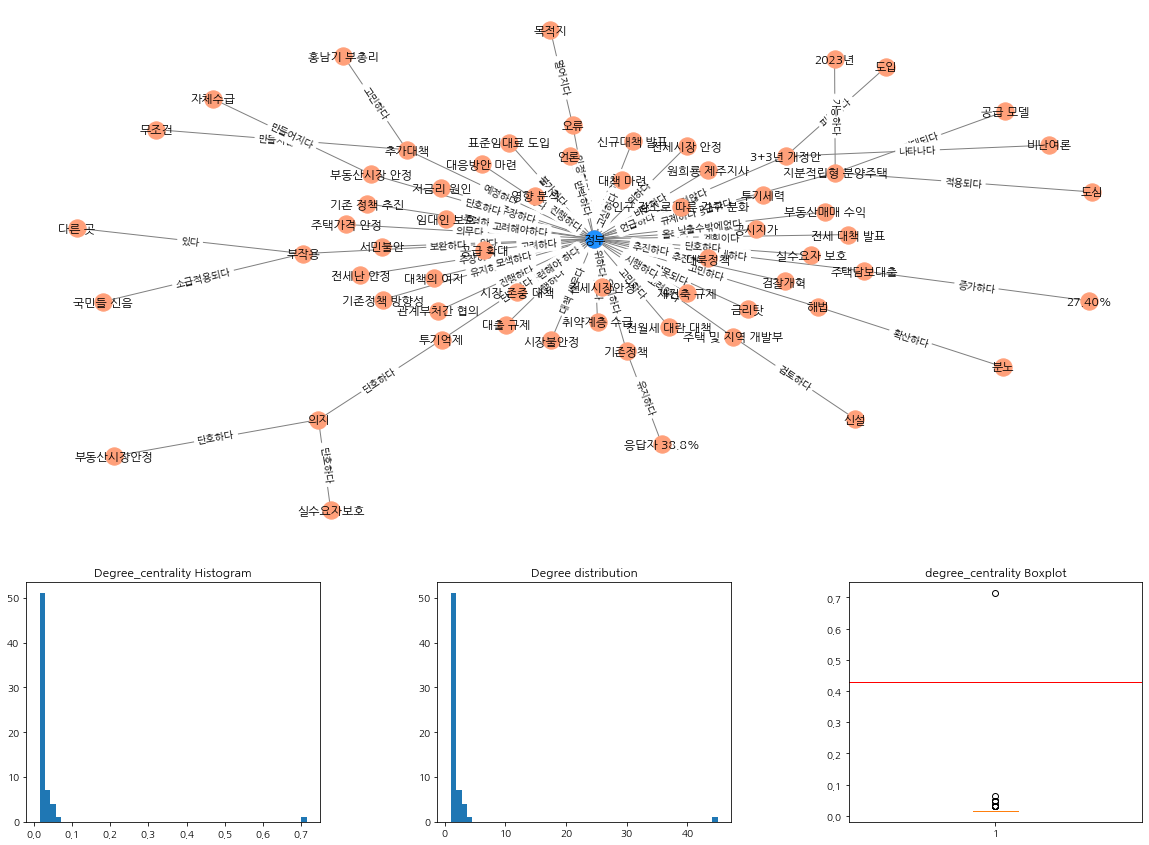

=================cluster 1 =================
# of Nodes : 58
selected_DC: {'임대차법': 0.6140350877192982}


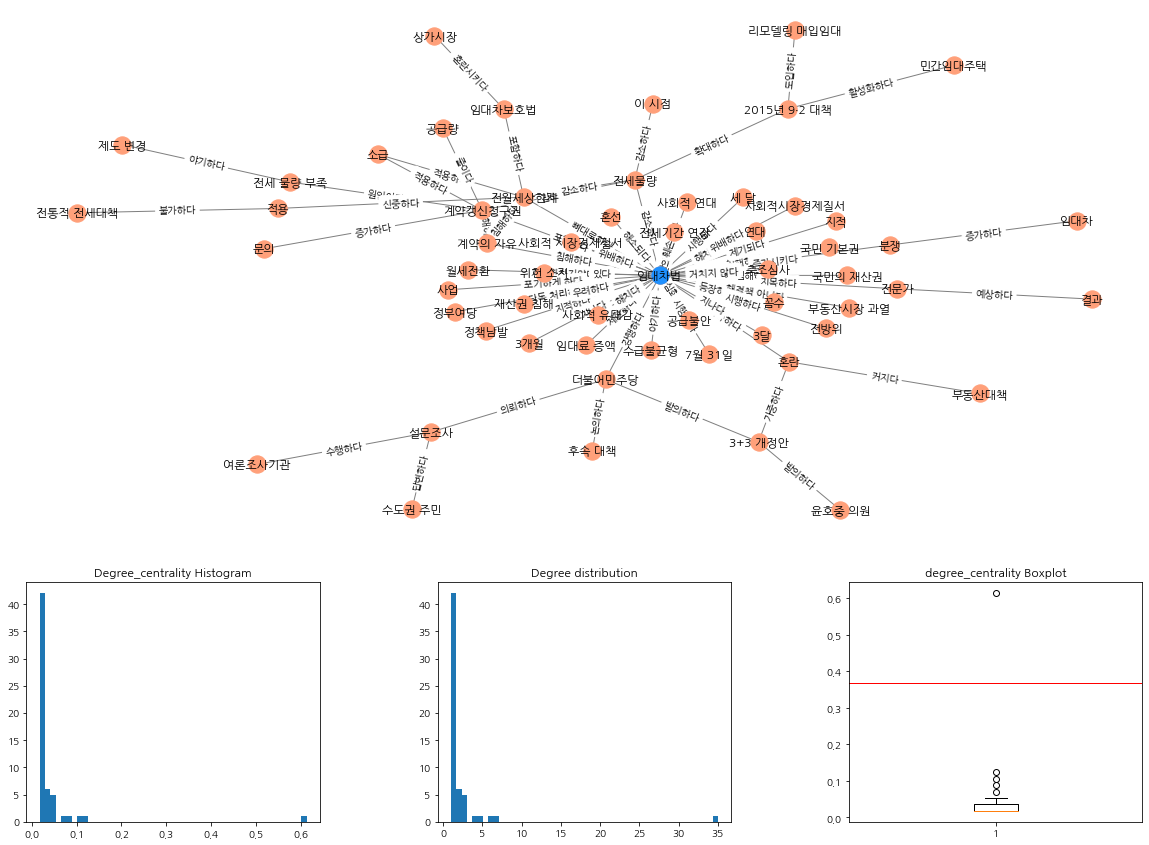

=================cluster 2 =================
# of Nodes : 52
selected_DC: {'전세대출': 0.37254901960784315}


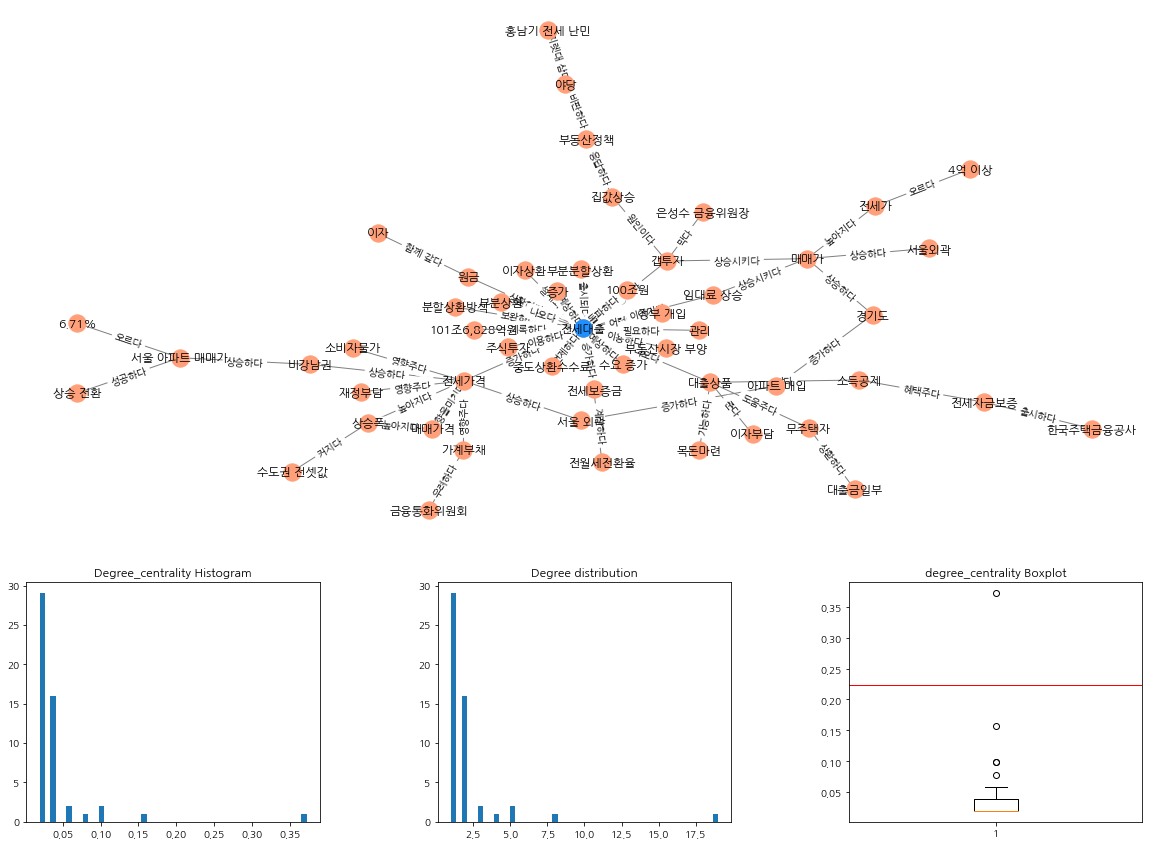

=================cluster 3 =================
# of Nodes : 47
selected_DC: {'전셋값': 0.6739130434782609}


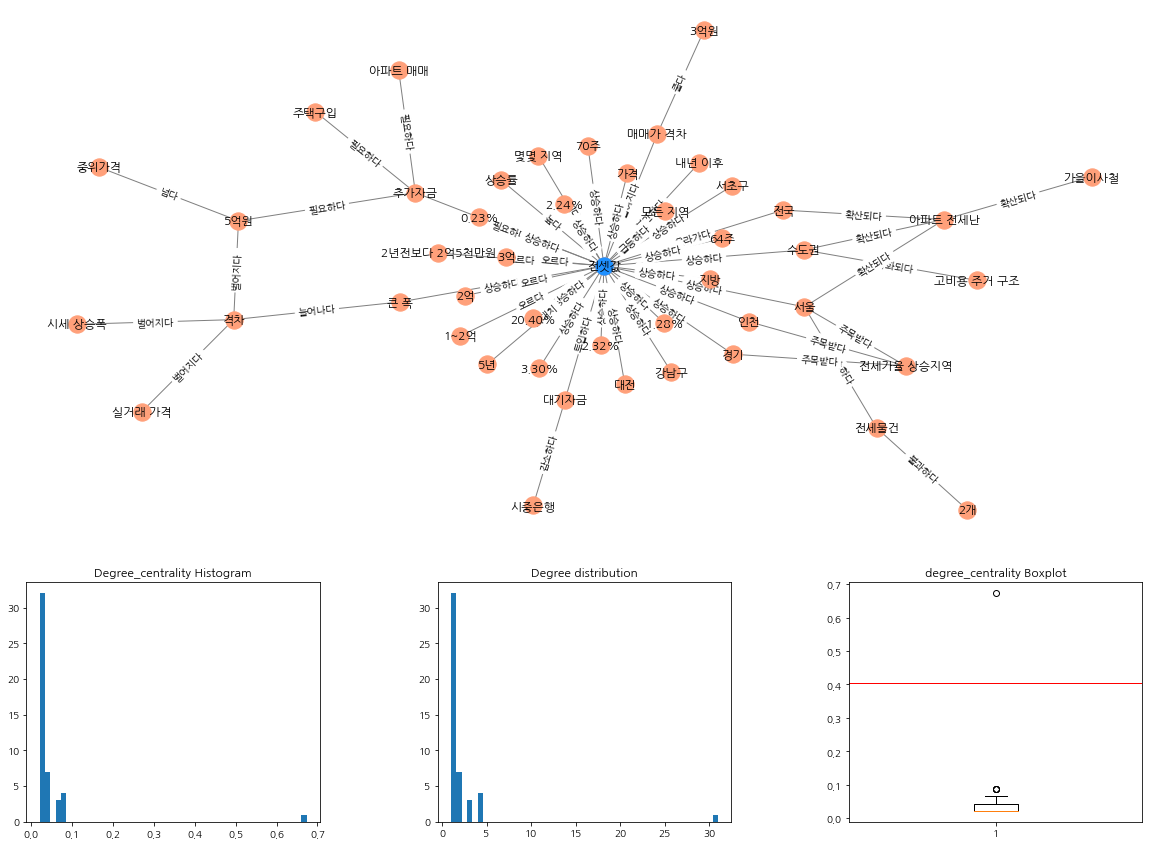

=================cluster 4 =================
# of Nodes : 35
selected_DC: {'집주인': 0.5294117647058824}


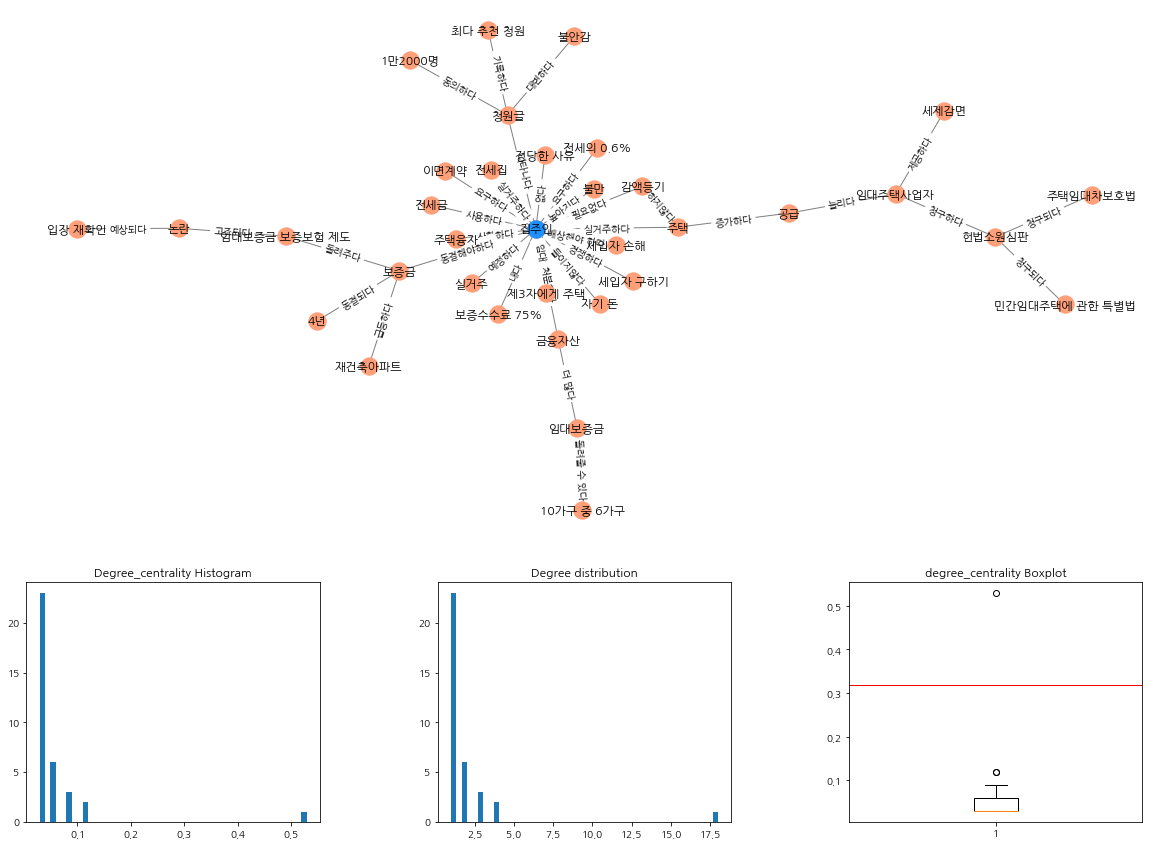

=================cluster 5 =================
# of Nodes : 33
selected_DC: {'대책': 0.25, '공공임대': 0.34375}


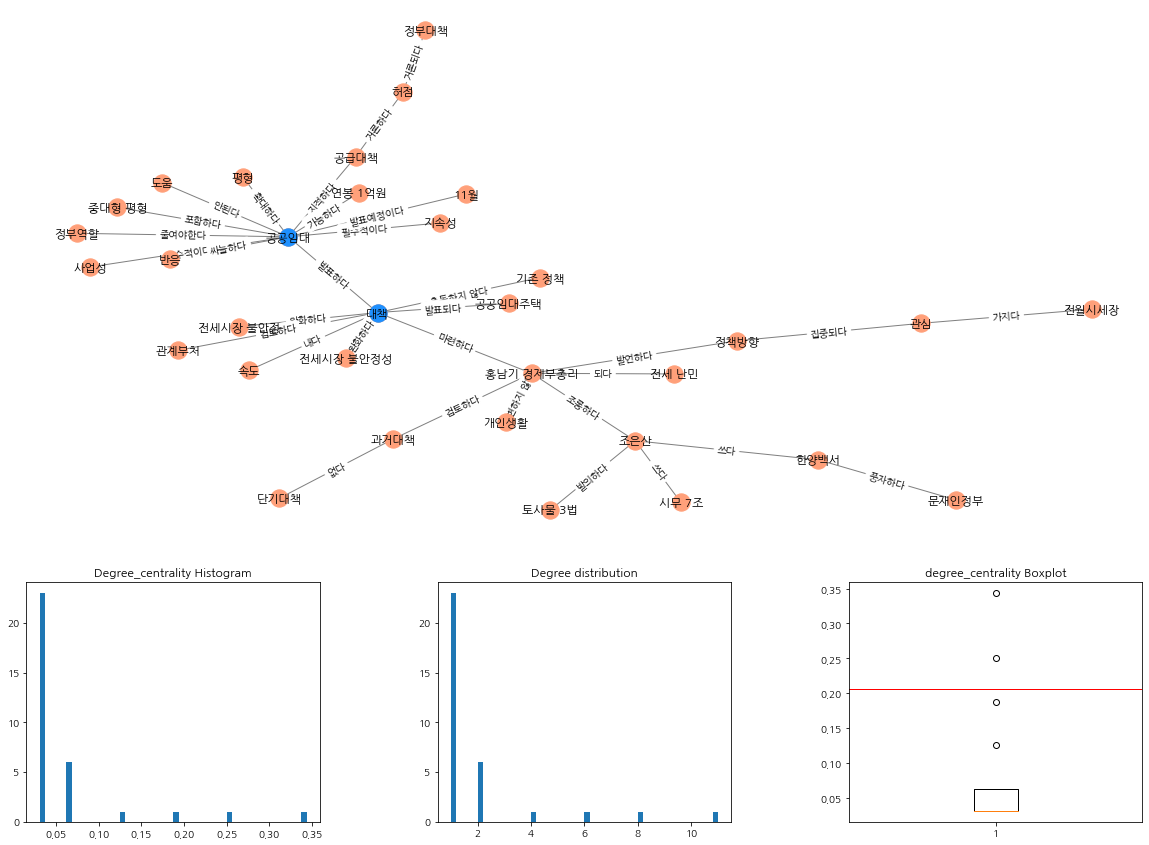

=================cluster 6 =================
# of Nodes : 30
selected_DC: {'전세난': 0.8620689655172413}


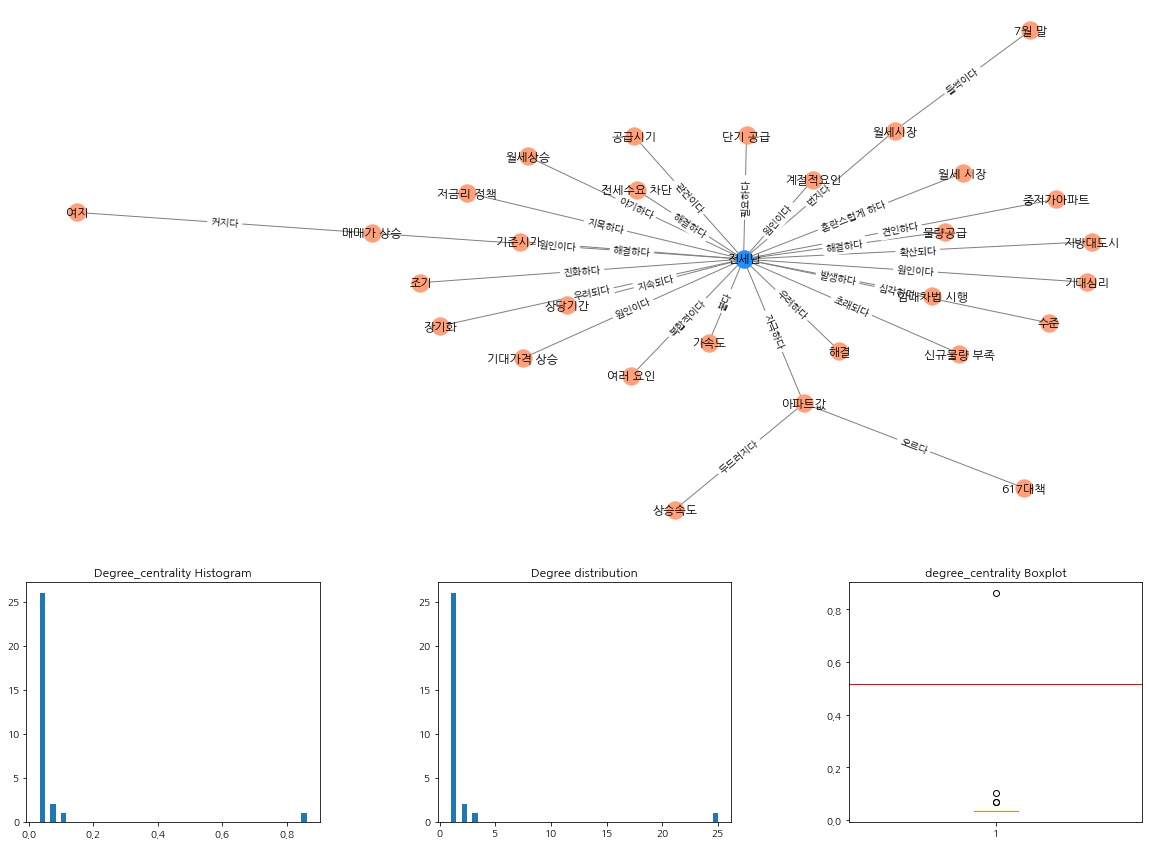

=================cluster 7 =================
# of Nodes : 30
selected_DC: {'전세': 0.3793103448275862}


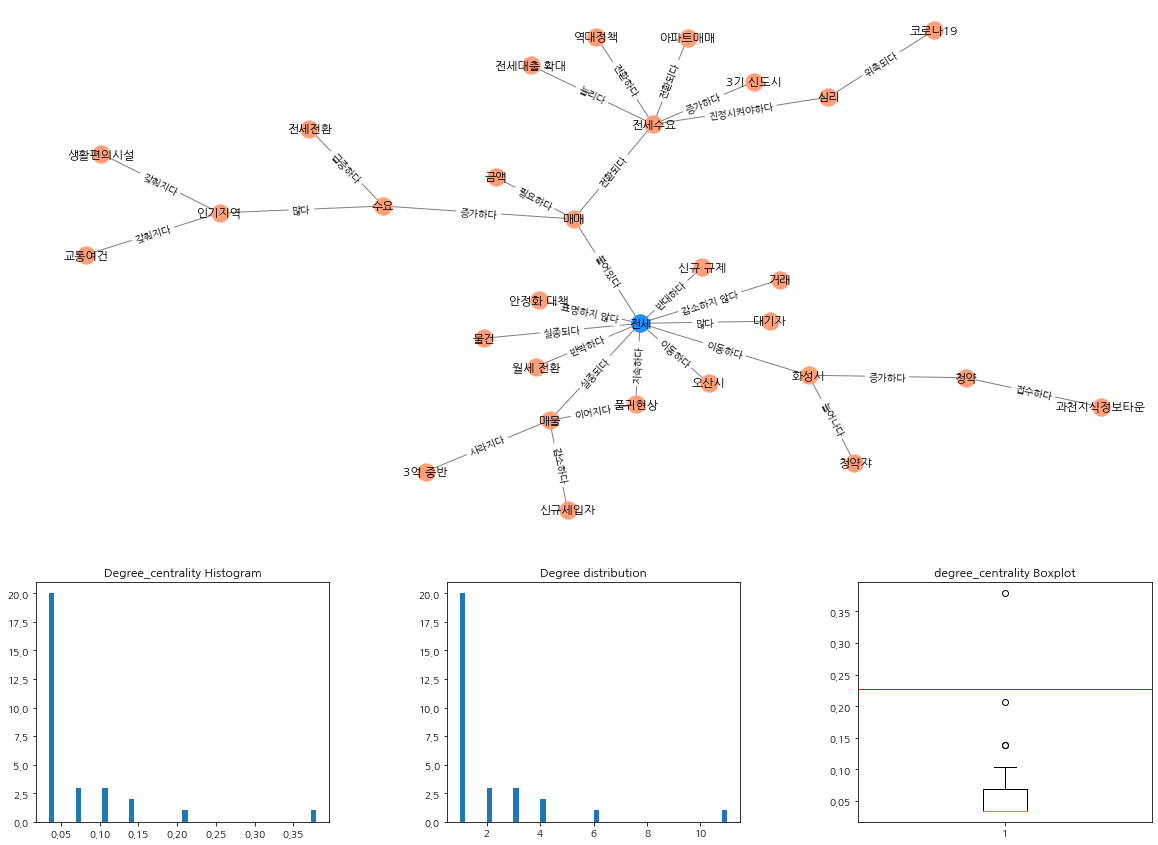

=================cluster 8 =================
# of Nodes : 29
selected_DC: {'저금리': 0.25}


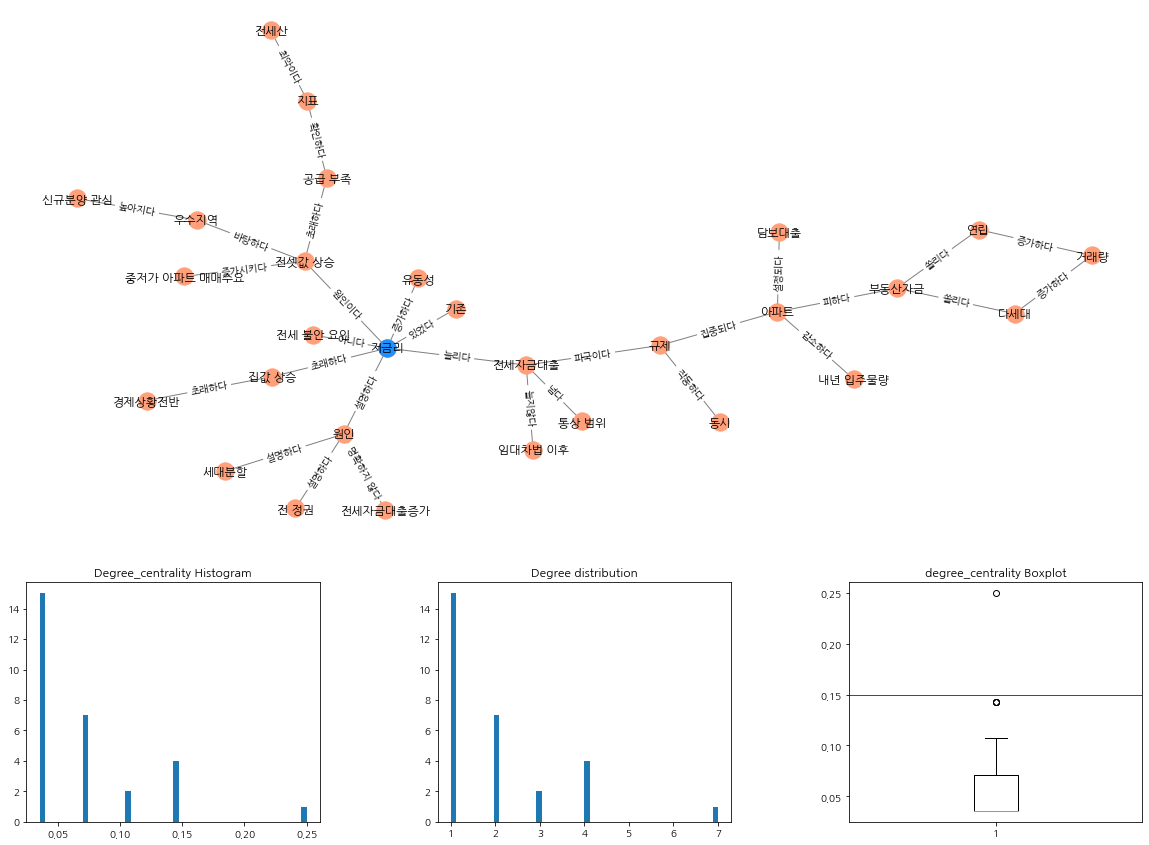

=================cluster 9 =================
# of Nodes : 27
selected_DC: {'부동산시장': 0.23076923076923078, '임차인': 0.34615384615384615}


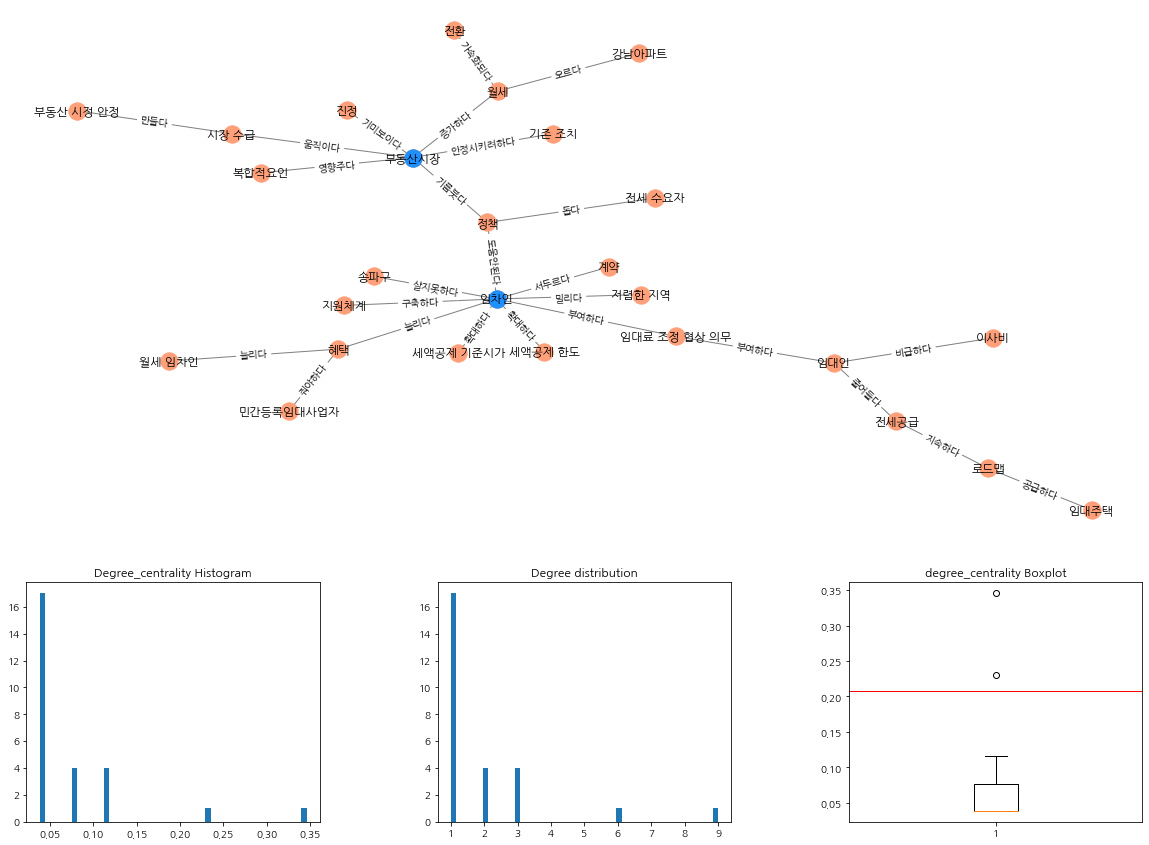

=================cluster 10 =================
# of Nodes : 27
selected_DC: {'세입자': 0.5}


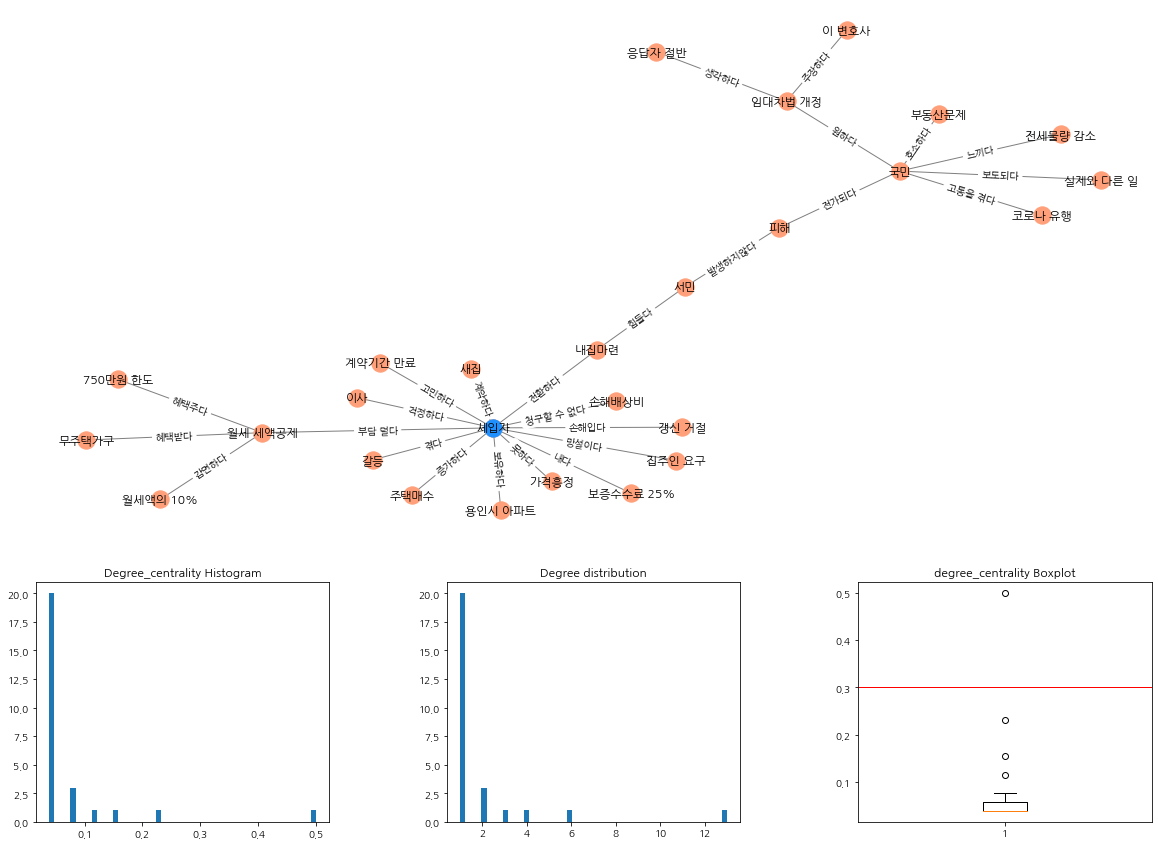

=================cluster 11 =================
# of Nodes : 25
selected_DC: {'임대차신고제': 0.25, '김현미 장관': 0.3333333333333333}


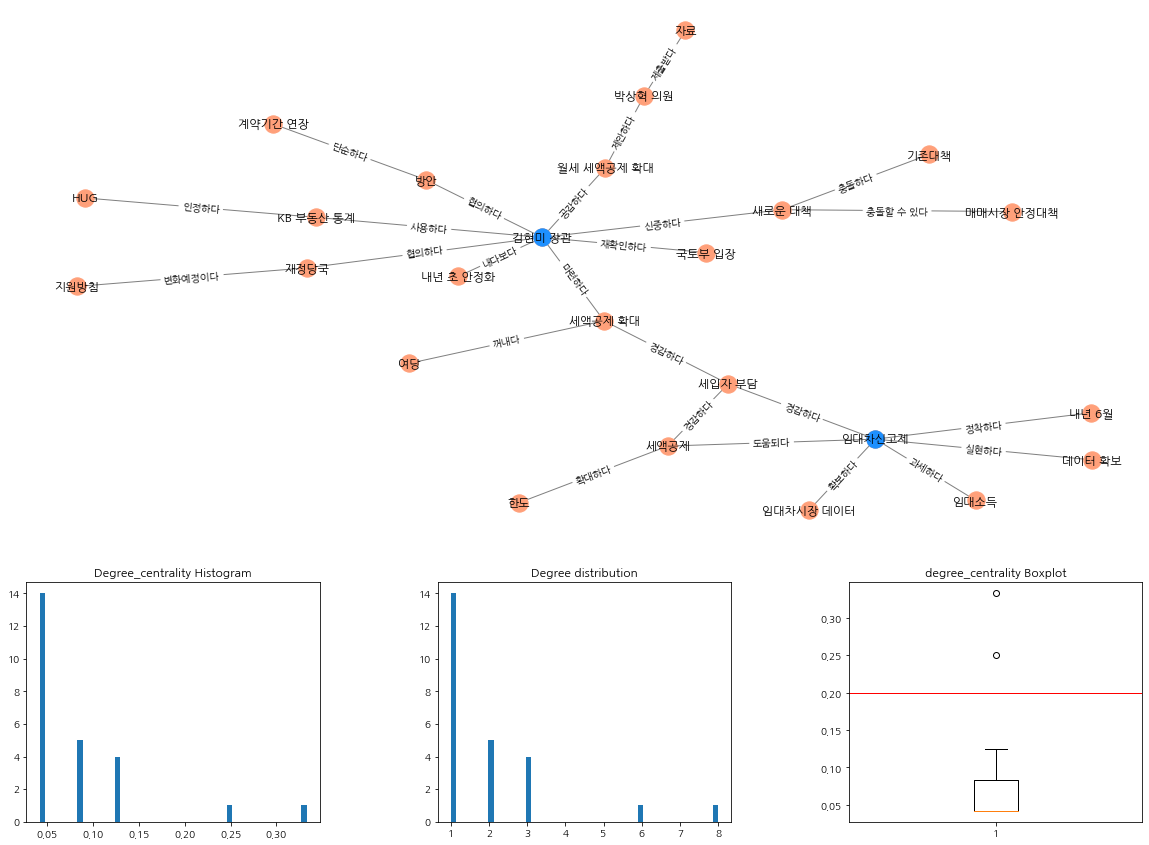

=================cluster 12 =================
# of Nodes : 20
selected_DC: {'국토교통부': 0.5789473684210527}


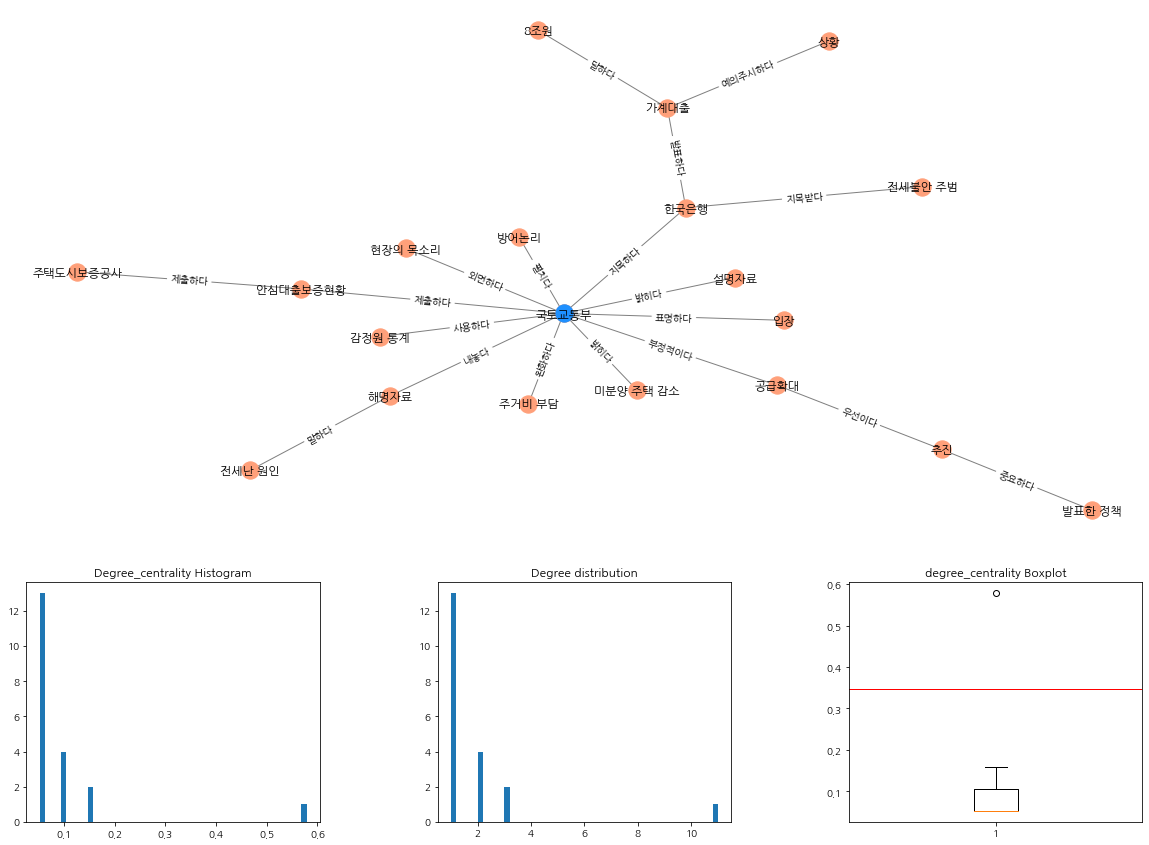

=================cluster 13 =================
# of Nodes : 20
selected_DC: {'시장': 0.5789473684210527}


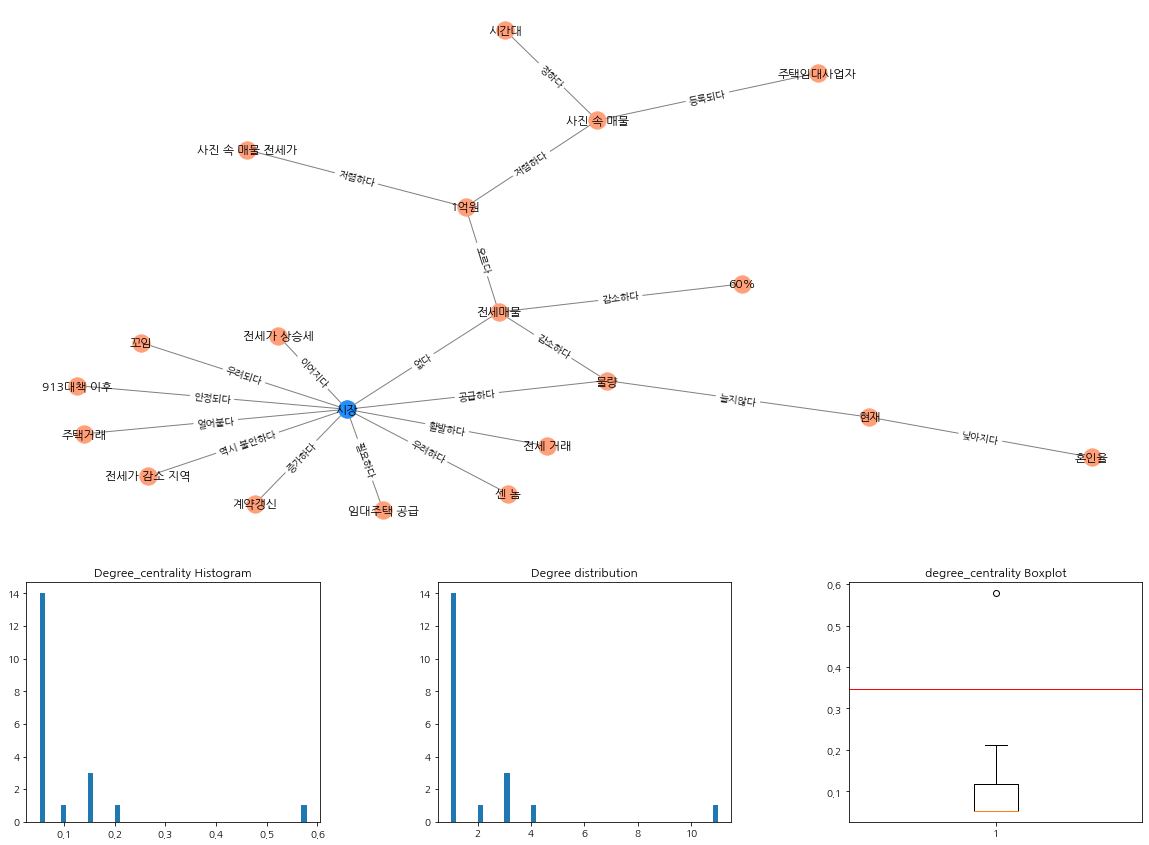

=================cluster 14 =================
# of Nodes : 18
selected_DC: {'전세시장': 0.47058823529411764}


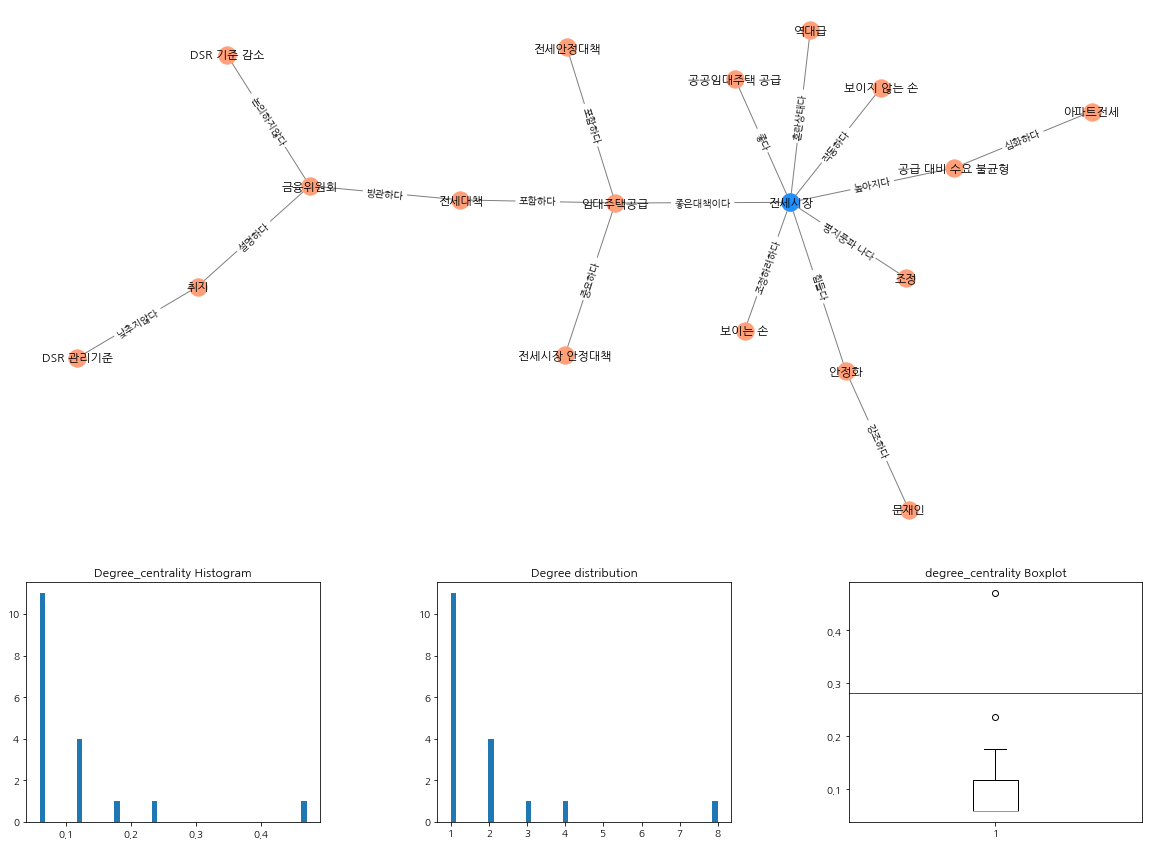

=================cluster 15 =================
# of Nodes : 17
selected_DC: {'매매시장': 0.3125, '상승세': 0.375, '중저가 아파트': 0.25}


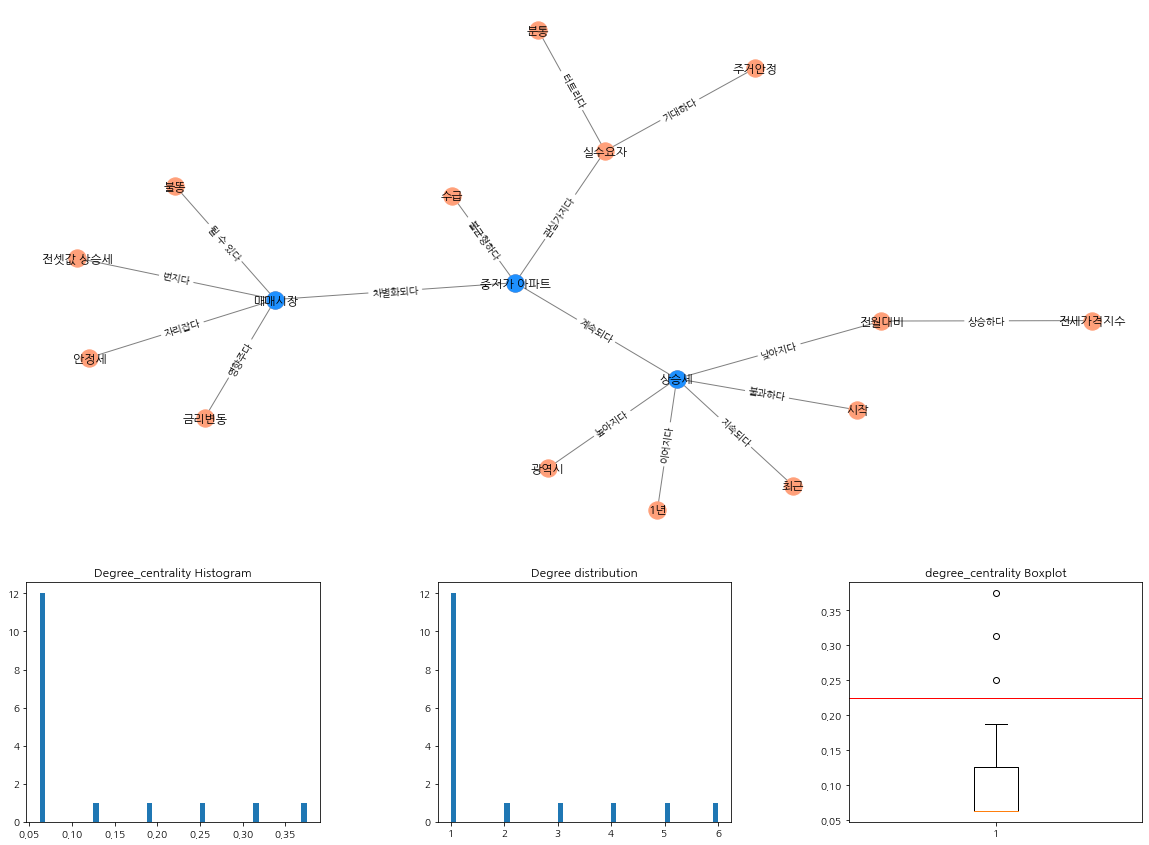

=================cluster 16 =================
# of Nodes : 15
selected_DC: {'임대료': 0.3571428571428571, '913대책': 0.21428571428571427, '집값': 0.2857142857142857}


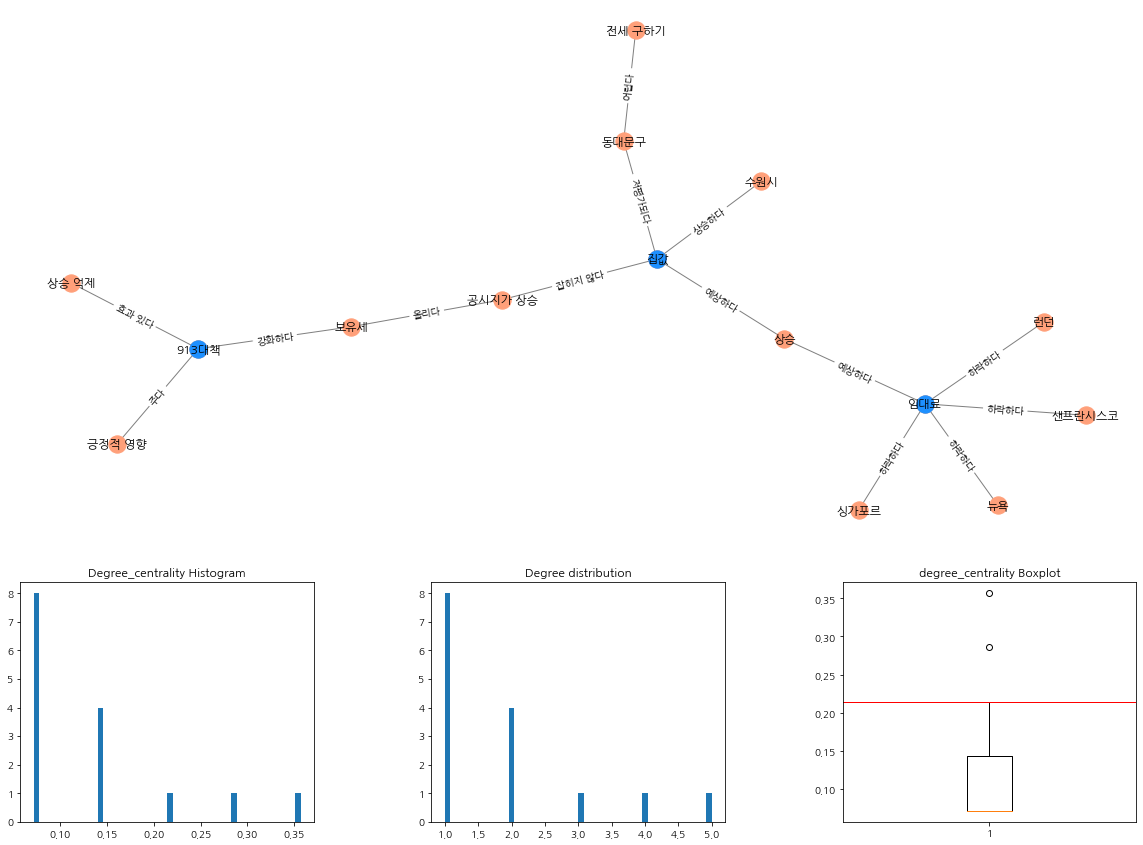

=================cluster 17 =================
# of Nodes : 8
selected_DC: {'디딤돌대출': 0.5714285714285714, '금리': 0.42857142857142855}


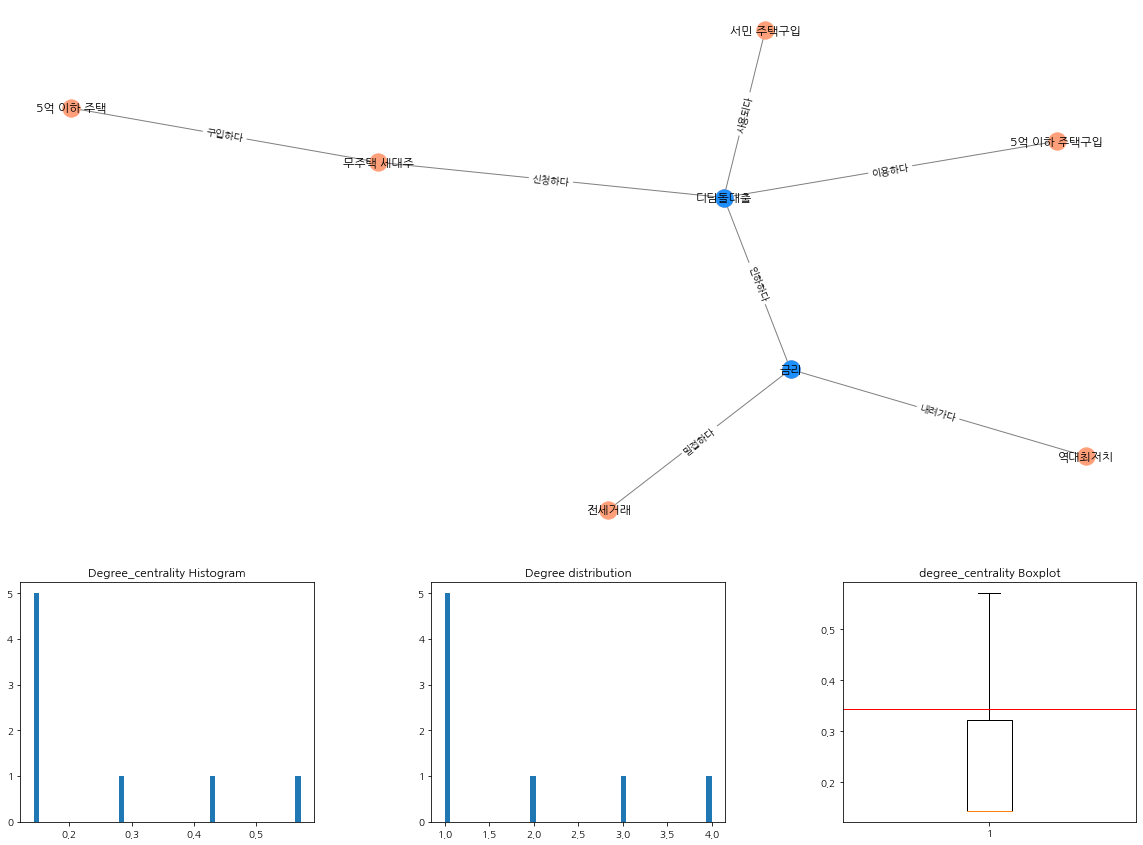

=================cluster 18 =================
# of Nodes : 8
selected_DC: {'서울 아파트 누적 변동률': 0.5714285714285714, '전세대란': 0.42857142857142855}


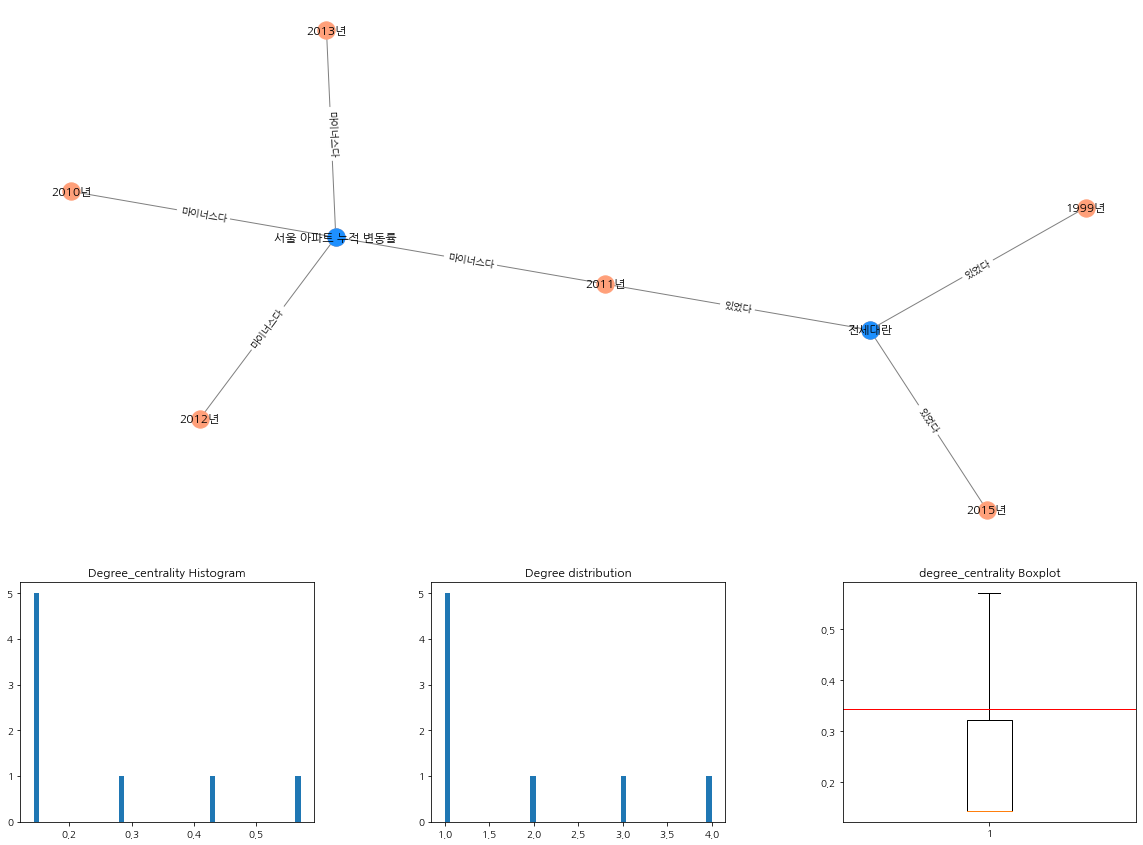

=================cluster 19 =================
# of Nodes : 6
selected_DC: {'주택 공급': 0.6000000000000001, '주택공급': 0.4, '확대': 0.4}


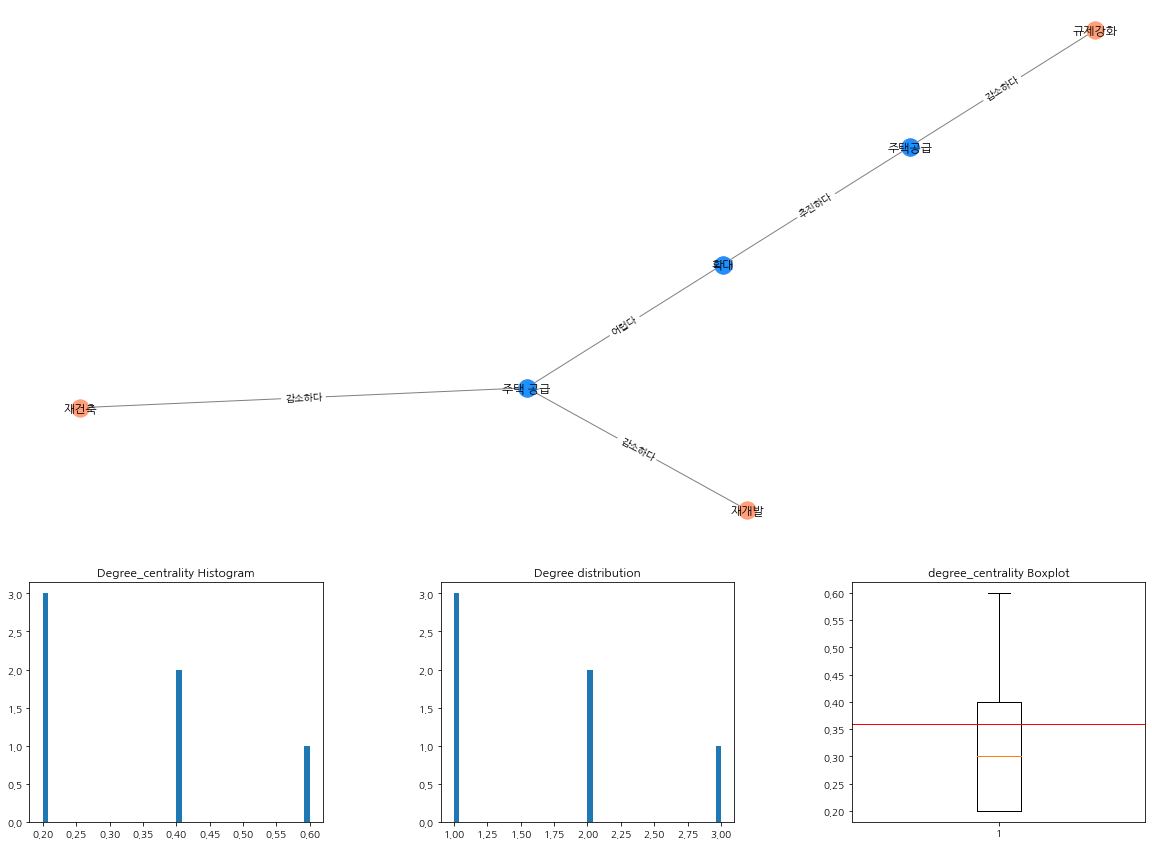

In [36]:
for i, sub_graph in enumerate(G_list):
    print('=================cluster', i,"=================")
#     print("betweenness_centrality max 값")
#     print(max(nx.betweenness_centrality(G), key=lambda k: nx.betweenness_centrality(G)[k]))
#     print("closeness_centrality max 값")
#     print(max(nx.closeness_centrality(G), key=lambda k: nx.closeness_centrality(G)[k]))
#     print("degree_centrality max 값")
#     print(max(nx.degree_centrality(G), key=lambda k: nx.degree_centrality(G)[k]))
    
    fig = plt.figure(figsize=(20, 15))
    grid = plt.GridSpec(3, 3, wspace=0.4, hspace=0.2)
    main_ax = fig.add_subplot(grid[:-1, 0:])
    sub1_ax =fig.add_subplot(grid[2:, 0:1])
    sub2_ax =fig.add_subplot(grid[2:, 1:2])
    sub3_ax =fig.add_subplot(grid[2:, 2:3])
    #레이아웃
    #planar_layout, rescale_layout, fruchterman_reingold_layout, spectral_layout, random_layout, bipartite_layout,
    #circular_layout, spring_layout, kamada_kawai_layout
    pos=nx.kamada_kawai_layout(sub_graph)
    nx.draw(sub_graph, pos, with_labels = True, font_weigth = "bold", font_family=font_name, edge_color='gray', node_color='lightsalmon',ax=main_ax)

    labels = nx.get_edge_attributes(sub_graph,'verb')
    nx.draw_networkx_edge_labels(sub_graph, pos, edge_labels=labels, font_family=font_name, ax=main_ax)
#     nx.draw_networkx_edges(G, pos, edgelist=key_edges[i], edge_color='r', width=3, ax=main_ax)

#     # edge_betweenness_centrality 그리기
#     tmp_ebc = nx.edge_betweenness_centrality(G)
#     for j in range(2):
#         max_val = max(tmp_ebc, key=lambda k: tmp_ebc[k])
#         tmp_ebc_1, tmp_ebc_2 =max_val[0],max_val[1]
#         del tmp_ebc[max_val]
#         nx.draw_networkx_nodes(G, pos, nodelist=[tmp_ebc_1,tmp_ebc_2], node_color='dodgerblue', ax=main_ax)
    
    # degree centrality Histogram
    dict_DC = nx.degree_centrality(sub_graph)
    max_DC = max(dict_DC.values())
    selected_DC = dict(filter(lambda dict_DC:dict_DC[1]>max_DC*0.6, dict_DC.items()))
    print("# of Nodes :", str(len(sub_graph)))
    print("selected_DC:", selected_DC)
    nx.draw_networkx_nodes(sub_graph, pos, nodelist=selected_DC, node_color='dodgerblue', ax=main_ax)
    
    sub1_ax.hist(nx.degree_centrality(sub_graph).values(), bins=50)
    sub1_ax.set_title("Degree_centrality Histogram")
    
    # degree distribution plotting
    tmp_degrees = [sub_graph.degree(n) for n in sub_graph.nodes()]
    sub2_ax.hist(tmp_degrees,bins=50)
    sub2_ax.set_title("Degree distribution")
    # Degree Centrality boxplot
    sub3_ax.boxplot(nx.degree_centrality(sub_graph).values())
    sub3_ax.set_title("degree_centrality Boxplot")
    sub3_ax.axhline(y=max_DC*0.6, color='r', linewidth=1)
    
    plt.show()

전체그래프

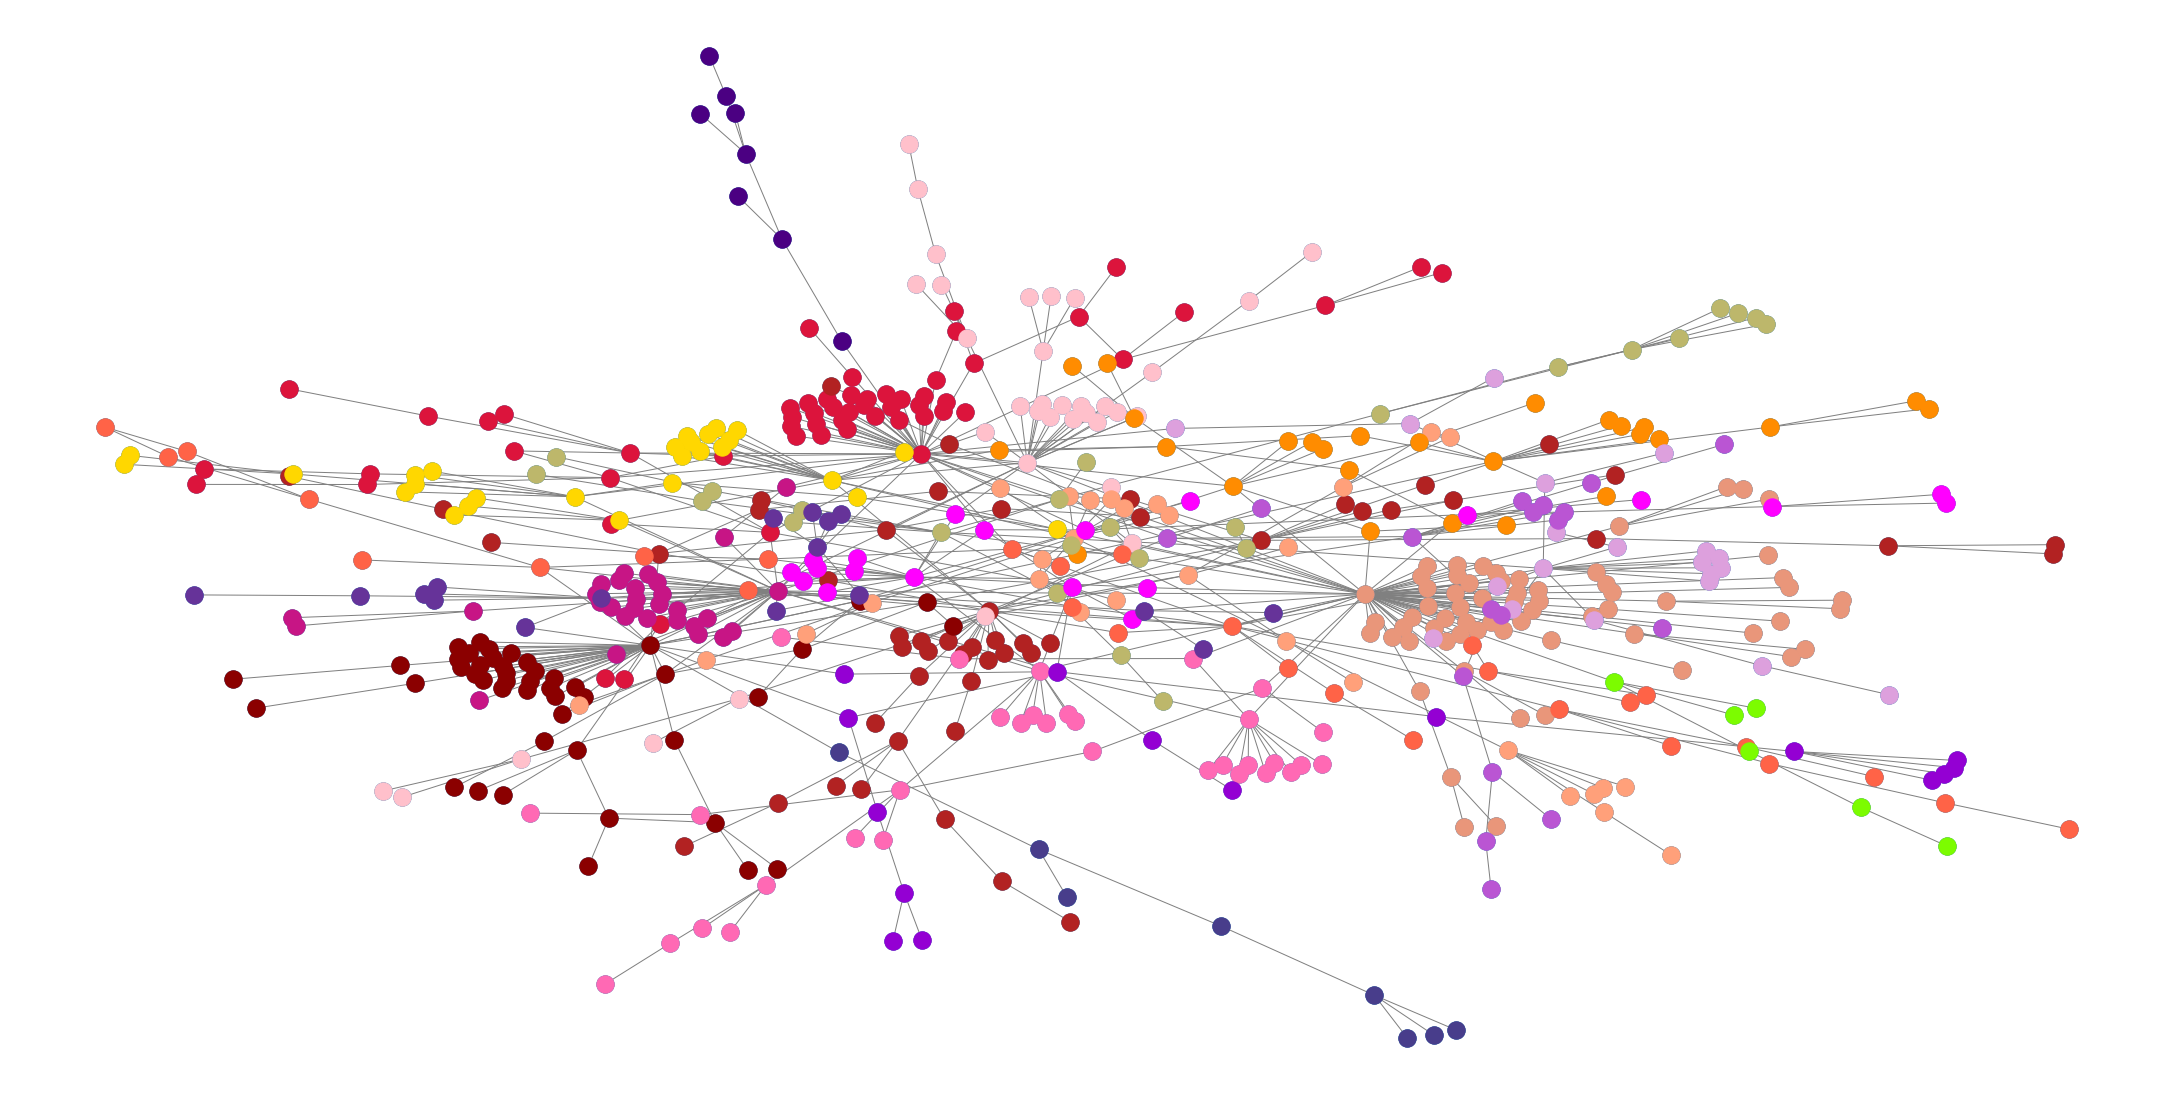

In [37]:
colors = ['#E9967A','#DC143C','#B22222','#8B0000','#FFC0CB','#FF69B4','#C71585','#FFA07A',\
         '#FF6347','#FF8C00','#FFD700','#BDB76B','#DDA0DD','#FF00FF','#BA55D3','#663399','#9400D3',\
         '#4B0082','#483D8B','#7CFC00','#2E8B57','#008000']

#레이아웃
#planar_layout, rescale_layout, fruchterman_reingold_layout, spectral_layout, random_layout, bipartite_layout,
#circular_layout, spring_layout, kamada_kawai_layout

# 전체 그래프 그리기
pos=nx.spring_layout(GC) 
plt.figure(figsize=(30, 15))
# nx.draw(GC, pos, with_labels = True, font_weigth = "bold", font_family=font_name, font_size=5, edge_color='gray')
nx.draw(GC, pos, edge_color='gray')

# 그룹이 n개로 나누어지게 node색 지정
n=len(clusters)
for i in range(n):
    nx.draw_networkx_nodes(GC,pos, nodelist=clusters[i], node_color=colors[i])   

plt.savefig('total_graph.png')